In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 500)

In [2]:
df = pd.read_parquet("../parquet_files/train.parquet")

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN


In [4]:
class FeatureSelection:
    def __init__(self, df: pd.DataFrame, target_col: str) -> None:
        self.dataframe = df
        self.target_col = target_col
        self.cols = self.dataframe.columns
    

    def get_dataframe_details(self, feature_selection_method: str) ->pd.DataFrame:
        """
        feature_selection_method: takes values such 'Missing_Values' and 'Variance' as selection method
        and returns dataframe for the respective method
        """
        if feature_selection_method == "Missing_Values":
            missing_pct = pd.DataFrame(columns=["Missing_Pct"], index=[self.cols])
            for col in self.cols:
                missing_pct.loc[col, "Missing_Pct"] = (self.dataframe[col].isnull().sum())/ len(self.dataframe) * 100
            return missing_pct
        elif feature_selection_method == "Variance":
            variance_df = pd.DataFrame(columns=["Variance"], index=[self.cols])
            for i in self.cols:
                variance_df.loc[i, "Variance"] = (self.dataframe[i].var())
            return variance_df

        else:
            raise Exception("Selection method not understood")

In [5]:
def get_nunique_value_from_categorical_col(df: pd.DataFrame) ->pd.DataFrame:
    cat_cols = df.select_dtypes(include="object").columns
    nunique_cat_vals = pd.DataFrame(columns=["Nunique"], index=[cat_cols])
    for col in cat_cols:
        nunique_cat_vals.loc[col, "Nunique"] = df[col].nunique()
    return nunique_cat_vals

In [6]:
missing_df = FeatureSelection(df=df, target_col='loan_status').get_dataframe_details(feature_selection_method="Missing_Values")

In [7]:
missing_df.tail()

,Missing_Pct
settlement_status,99.633383
settlement_date,99.633383
settlement_amount,99.633383
settlement_percentage,99.633383
settlement_term,99.633383


In [8]:
missing_df.reset_index(inplace=True)
col_to_drop = missing_df[missing_df.Missing_Pct >= 50]['level_0']
df.drop(col_to_drop, axis=1, inplace=True)

In [9]:
print(get_nunique_value_from_categorical_col(df=df))
cat_cols_to_drop = ["emp_title", "issue_d", "title", "zip_code", "addr_state", "earliest_cr_line", 
                        "last_pymnt_d", "next_pymnt_d", "last_credit_pull_d"]

                     Nunique
term                       2
grade                      7
sub_grade                 35
emp_title             143725
emp_length                11
home_ownership             4
verification_status        3
issue_d                   15
loan_status                7
pymnt_plan                 2
purpose                   13
title                     12
zip_code                 905
addr_state                50
earliest_cr_line         687
initial_list_status        2
last_pymnt_d              31
next_pymnt_d               4
last_credit_pull_d        32
application_type           2
hardship_flag              2
disbursement_method        2
debt_settlement_flag       2


In [10]:
df.drop(cat_cols_to_drop, axis=1, inplace=True)

In [11]:
cat_cols = df.select_dtypes(include="object").columns
cat_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'pymnt_plan', 'purpose',
       'initial_list_status', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')

In [12]:
df[cat_cols] = df[cat_cols].astype("category")

In [13]:
df[cat_cols].dtypes

term                    category
grade                   category
sub_grade               category
emp_length              category
home_ownership          category
verification_status     category
loan_status             category
pymnt_plan              category
purpose                 category
initial_list_status     category
application_type        category
hardship_flag           category
disbursement_method     category
debt_settlement_flag    category
dtype: object

In [14]:
def imputer(df: pd.DataFrame) ->pd.DataFrame:
    for c in df.columns:
        if c in df.select_dtypes(include="int").columns:
            df.loc[:, c].fillna(df[c].median(), inplace=True)
        elif c in df.select_dtypes(include='object').columns:
            df.loc[:, c].fillna(df[c].mode()[0], inplace=True)
        return df

In [15]:
df = imputer(df)
df.isnull().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
                             ..
total_bc_limit                0
total_il_high_credit_limit    0
hardship_flag                 0
disbursement_method           0
debt_settlement_flag          0
Length: 93, dtype: int64

In [21]:
dtypes_df = pd.DataFrame(columns=["Dtypes"], index=[df.columns])
for c in df.columns:
    dtypes_df.loc[c, "Dtypes"] = df[c].dtypes

In [ ]:
def lbl_encoding(df: pd.DataFrame) ->pd.DataFrame:
    cat_cols = df.select_dtypes(include="category").columns
    for c in cat_cols:
        df[c] = df[c].cat.codes
    return df

In [ ]:
df = lbl_encoding(df)

In [ ]:
df.loan_status.value_counts().plot(kind="bar")

In [37]:
num_cols = df.columns[(df.dtypes == "float64") | (df.dtypes == "int64")]

In [40]:
corr = df[num_cols].corr()

# Select the upper triangle of the correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

/var/folders/xf/_6m_tb052fn5p84tlt773rqr0000gn/T/ipykernel_1940/2977694870.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


In [50]:
# Find index of feature columns with correlation greater than a threshold
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop

['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_rec_prncp',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_util',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'num_tl_op_past_12m',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

<AxesSubplot:>

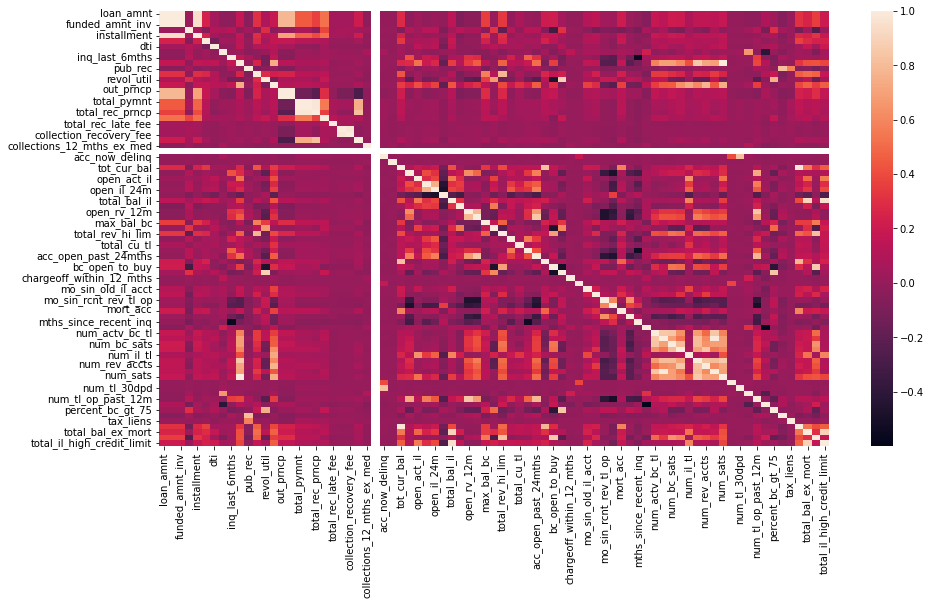

In [48]:
plt.figure(figsize = (15, 8))
sns.heatmap(corr, annot=False)